# Harry Reid International Airport Passenger Volume Forecast
### Which month has the highest enplanement and deplanement at LAS?

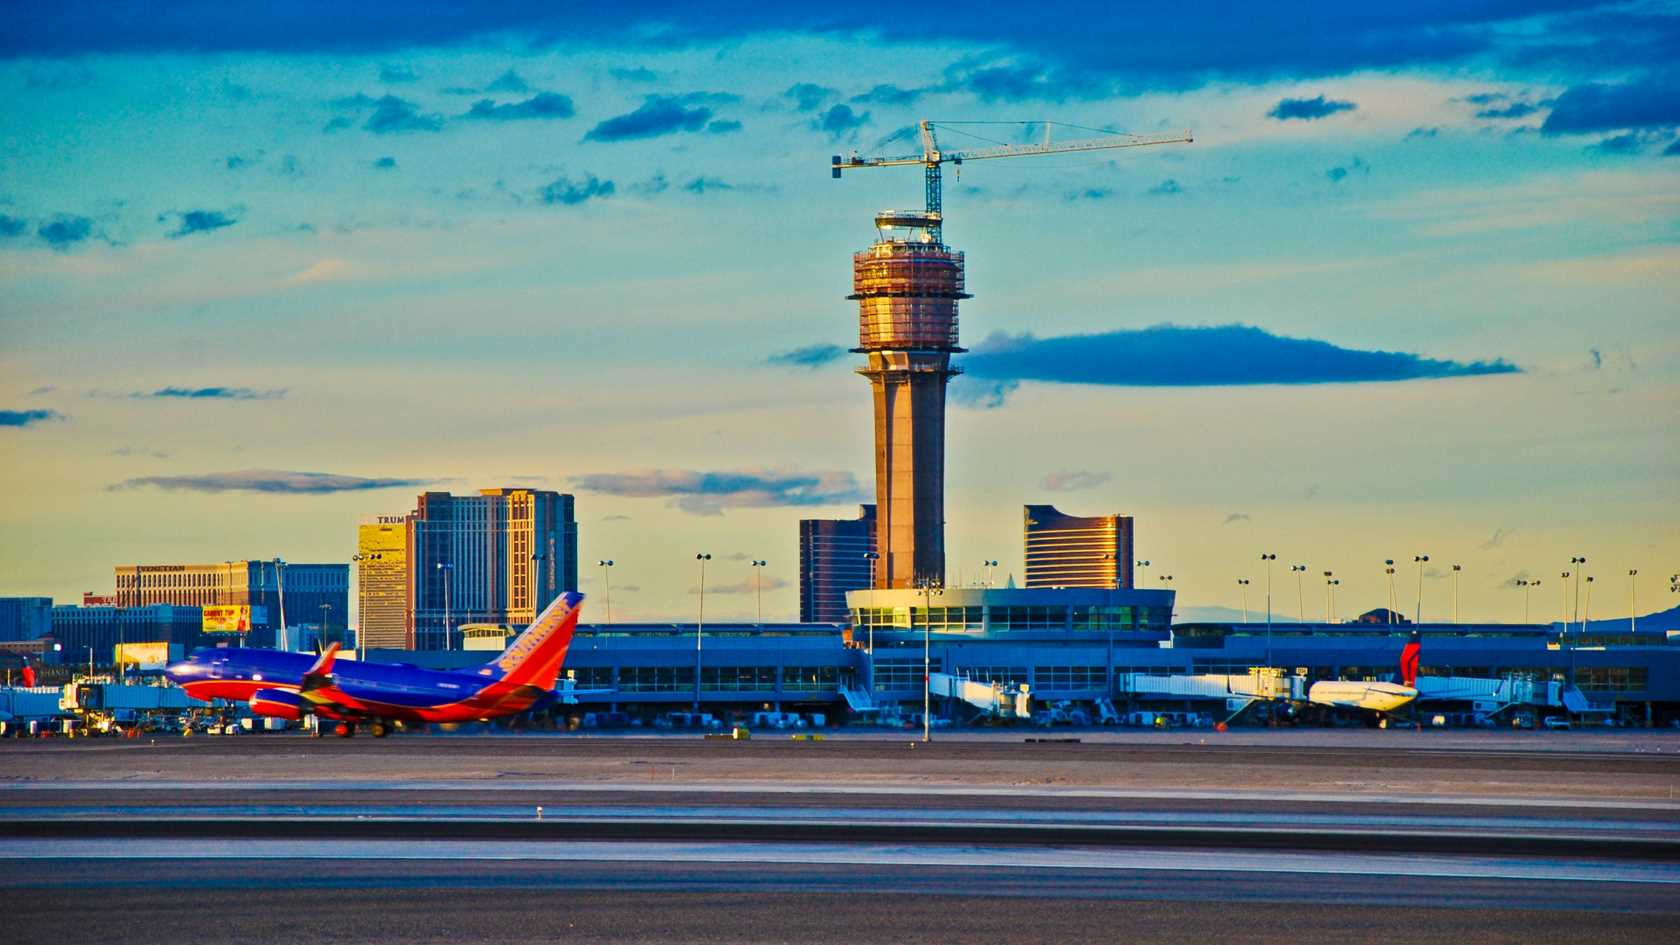

## Introduction
__Las Vegas__ is an internationally renowned major resort city and attracts millions of visitors annually. Understanding passenger trends helps local businesses anticipate demand and tailor their services, ultimately boosting the local economy. This is crucial for the city, as the leisure and hospitality industry (casinos, hotels, restaurants, entertainment, etc.) forms the backbone of the local economy. 


In this project, we will explore the passenger volume dataset and build a model to forecast passenger volumes at Harry Reid International Airport for the next 12 months.

Below is a sneak peak of the 12-month passenger volume forecasting from our final model. 

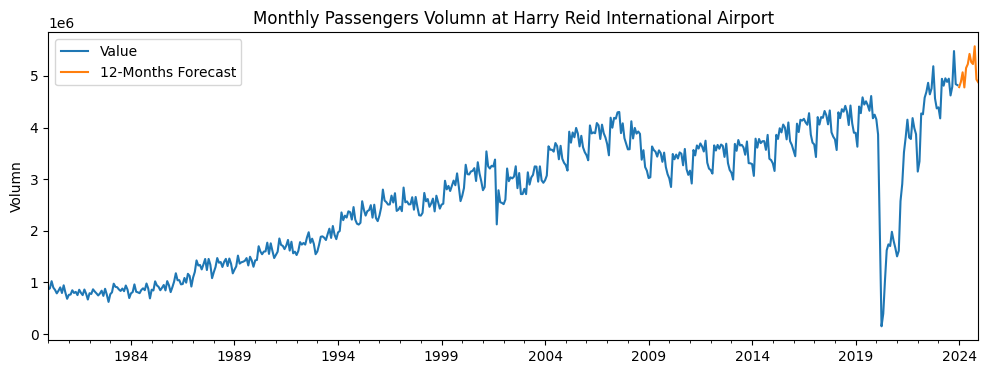

## Outline
1. Importing Libraries
2. Defining Functions
3. Reading Data
 - Date Index
 - Data Type
4. Understanding Evaluation Metric
5. Train/Test Split
6. EDA
 - Plot the Training Data
 - Seasonal Decomposition
7. Model 1: Triple Exponential Smoothing Algorithm (Holt-Winters)
8. EDA Part 2
 - Stationarity
 - Auto Correlation / Partial Auto Correlation
9. Model 2: ARIMA-based Algorithms
 - Understand ARIMA Components
 - Choosing ARIMA Orders
 - Exogenous Variables (Holidays/Special Events/Months)
10. Model 3: Hybrid
 - Linear Regression (Trend/Seasonality)
 - XGBRegressor (Residuals)
11. Retrain the Final Model on the Full Data
12. Forecasting 12-Months Ahead
13. Summary
14. Supplimental Data
 - Relationship between Passenger Volume and Gas Price
 - LSTM Deep Learning Model

## Importing Libraries

In [2]:
# pip install pmdarima

In [70]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf, month_plot, quarter_plot
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Input, Dense
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error

## Defining Functions

In [4]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


def create_holiday_df(country_holidays, years, holiday_col_name):
    holiday_list = []
    
    for year in years:
        holidays_for_year = country_holidays(years=year)
        for date, name in holidays_for_year.items():
            holiday_list.append({'Date': date, holiday_col_name: name})
    
    holiday_df = pd.DataFrame(holiday_list)
    holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])
    
    return holiday_df


def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


def add_temperature_level(df):
    df['Low_Temperature'] =  np.where(df.index.month.isin([11,12,1,2]), 1, 0)
    df['Moderate_Temperature'] =  np.where(df.index.month.isin([3,4,5,10]), 1, 0)
#     df['High_Temperature'] =  np.where(df.index.month.isin([6,7,8]), 1, 0)
    
    return df


def add_special_events(df):
    # 911 incident, grobal recession, covid19 pandemic
    mask = (df.index == '2001-09-01') | ((df.index >= '2007-12-01') & (df.index <= '2009-09-01')) | ((df.index >= '2020-03-01') & (df.index <= '2021-12-01'))
    df['Special_Events'] = np.where(df.index.isin(df[mask].index),1,0)
    
    return df

## Reading Data
The original data can be accessed from the Las Vegas Convention And Visitors Authority's [Tourism Tracker](https://www.lvcva.com/research/?tab=tourism-tracker#tab-container) database.

In [5]:
# including both en/deplained passengers
df = pd.read_csv('/kaggle/input/harry-reid-airport-passengers-1980-2023/Harry Reid International Airport Passengers 1980-2023.csv', index_col = 'Date', parse_dates=True)
original= pd.read_csv('/kaggle/input/original-passenger-data/Harry Reid International Airport Passengers - original.csv', index_col = 'Date', parse_dates=True)

df.head()

,Value
Date,
1980-01-01,"865,759"
1980-02-01,"886,371"
1980-03-01,"1,025,072"
1980-04-01,"901,473"
1980-05-01,"856,507"


### Date Index
DatetimeIndex does not have a set frequency (``freq``) in a time series DataFrame.

In [6]:
df.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=528, freq=None)

By setting the frequency, we are explicitly telling pandas that our data follows a regular time interval. This can help catch inconsistencies or missing data points in our time series. Also, many time series analysis functions in pandas and other libraries often work better with a set frequency. 

<table style="display: inline-block">
    <caption style="text-align: center"><strong>TIME SERIES OFFSET ALIASES</strong></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>B</td><td>business day frequency</td></tr>
<tr><td>C</td><td>custom business day frequency (experimental)</td></tr>
<tr><td>D</td><td>calendar day frequency</td></tr>
<tr><td>W</td><td>weekly frequency</td></tr>
<tr><td>M</td><td>month end frequency</td></tr>
<tr><td>SM</td><td>semi-month end frequency (15th and end of month)</td></tr>
<tr><td>BM</td><td>business month end frequency</td></tr>
<tr><td>CBM</td><td>custom business month end frequency</td></tr>
<tr><td>MS</td><td>month start frequency</td></tr>
<tr><td>SMS</td><td>semi-month start frequency (1st and 15th)</td></tr>
<tr><td>BMS</td><td>business month start frequency</td></tr>
<tr><td>CBMS</td><td>custom business month start frequency</td></tr>
<tr><td>Q</td><td>quarter end frequency</td></tr>
<tr><td></td><td><font color=white>intentionally left blank</font></td></tr></table>

<table style="display: inline-block; margin-left: 40px">
<caption style="text-align: center"></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>BQ</td><td>business quarter endfrequency</td></tr>
<tr><td>QS</td><td>quarter start frequency</td></tr>
<tr><td>BQS</td><td>business quarter start frequency</td></tr>
<tr><td>A</td><td>year end frequency</td></tr>
<tr><td>BA</td><td>business year end frequency</td></tr>
<tr><td>AS</td><td>year start frequency</td></tr>
<tr><td>BAS</td><td>business year start frequency</td></tr>
<tr><td>BH</td><td>business hour frequency</td></tr>
<tr><td>H</td><td>hourly frequency</td></tr>
<tr><td>T, min</td><td>minutely frequency</td></tr>
<tr><td>S</td><td>secondly frequency</td></tr>
<tr><td>L, ms</td><td>milliseconds</td></tr>
<tr><td>U, us</td><td>microseconds</td></tr>
<tr><td>N</td><td>nanoseconds</td></tr></table>

In [7]:
df.index.freq = 'MS'
original.index.freq = 'MS'

df.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Date', length=528, freq='MS')

### Data Type
The current data type of ``Value`` is object.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1980-01-01 to 2023-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Value   528 non-null    object
dtypes: object(1)
memory usage: 8.2+ KB


We need to first remove a comma and then convert it to a numeric data type.

In [9]:
df['Value'] = df['Value'].str.replace(',', '').astype(np.int32)
original['Value'] = original['Value'].str.replace(',', '').astype(np.int32)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1980-01-01 to 2023-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Value   528 non-null    int32
dtypes: int32(1)
memory usage: 6.2 KB


## Understanding Evaluation Metric

In this project, we will evaluate our models based on Root Mean Squared Error (RMSE). 

## Train/Test Split

Let's split the data into training and test sets. Since I want the final model to forecast a 1-year horizon, the test set should also contain at least 1 year of data.

In [10]:
train = df.iloc[:-12] # 1980-2022
test = df.iloc[-12:] # year 2023

## EDA

In [11]:
all_df = df.copy()
train_eda = train.copy()
test_eda = test.copy()

### Plot the Training Data

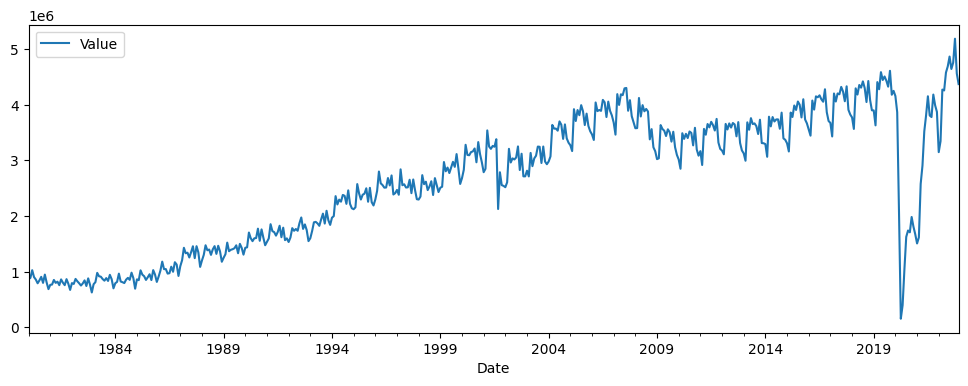

In [12]:
train_eda.plot(figsize=(12,4));

### Seasonal Decomposition
Statsmodels provides a _seasonal decomposition_ tool we can use to separate out the different components (trend/seasonality/error). This lets us see quickly and visually what each component contributes to the overall behavior.

We apply an __additive__ model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers).
A __multiplicative__ model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of passengers).

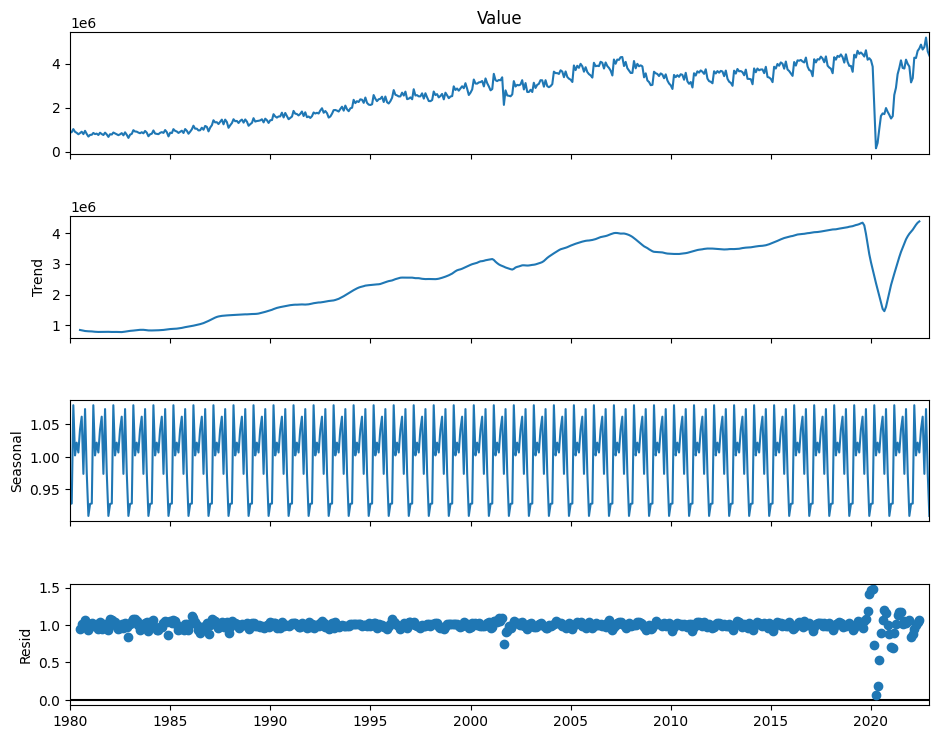

In [13]:
result = seasonal_decompose(train_eda['Value'], model = 'multiplicative')
fig = result.plot()

fig.set_size_inches(10, 8)

We can also plot them separately.

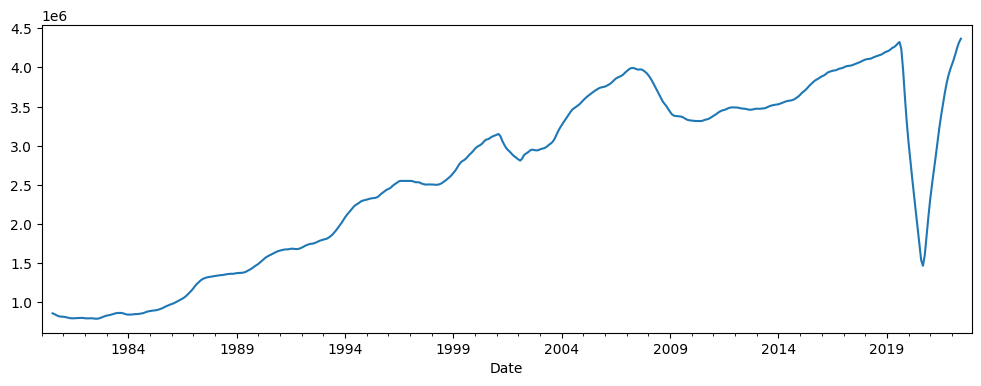

In [14]:
result.trend.plot(figsize = (12,4));

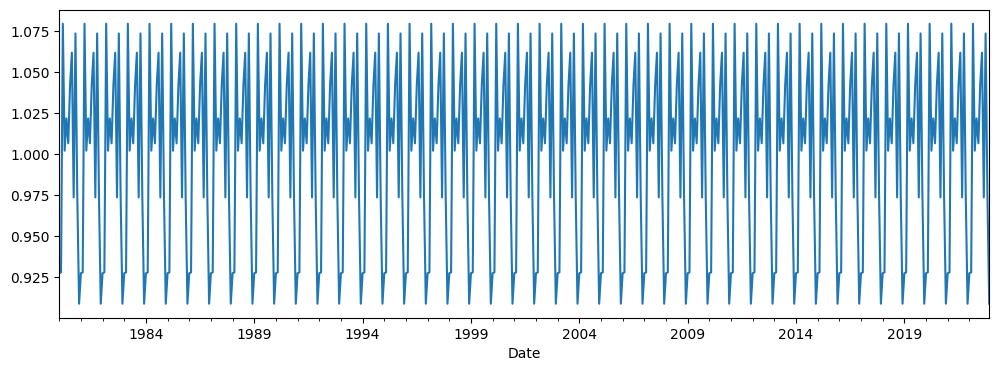

In [15]:
result.seasonal.plot(figsize = (12,4));

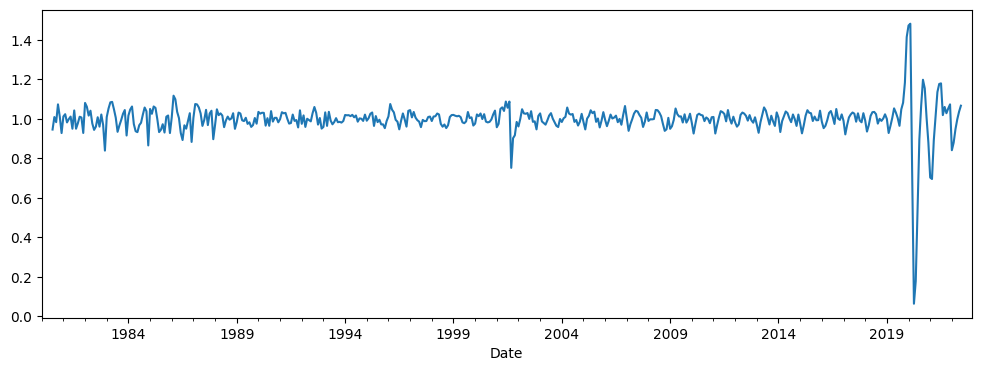

In [16]:
result.resid.plot(figsize = (12,4));

Notes on the plots above:
- There is a clear trend and seasonality. 
- We can also observe downward trends in 2001, 2008-2009, and 2020-2021. These are most likely due to the 9/11 incident, the global recession, and the COVID-19 pandemic, respectively. In fact, if you take a look at the residual plot, the plot is mostly a straight line except for those years. These deviations are likely influenced by factors not included in the current dataset, which only contains passenger volumn data. 

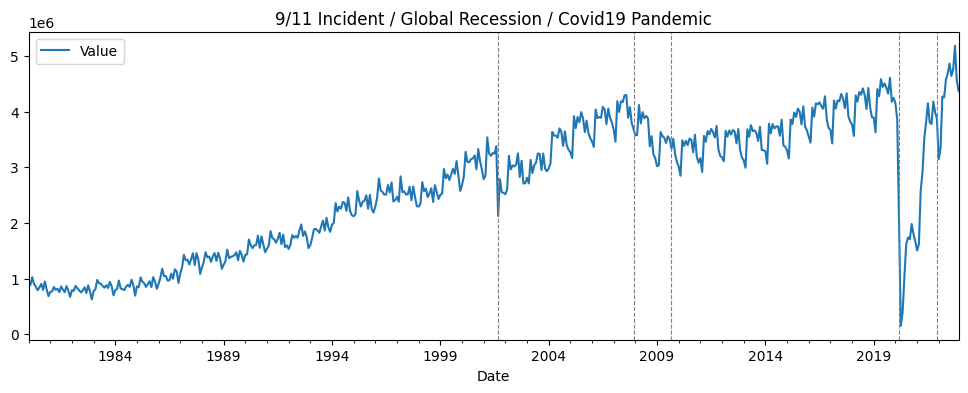

In [17]:
train_eda.plot(figsize=(12, 4))

vline_dates = ['2001-09-01', '2007-12-01', '2009-09-01', '2020-03-01', '2021-12-01']

vline_dates = pd.to_datetime(vline_dates)

for date in vline_dates:
    plt.axvline(x=date, color='gray', linestyle='--', linewidth=0.8)

plt.title('9/11 Incident / Global Recession / Covid19 Pandemic');

Statsmodels also has plotting functions that group data by month and by quarter.

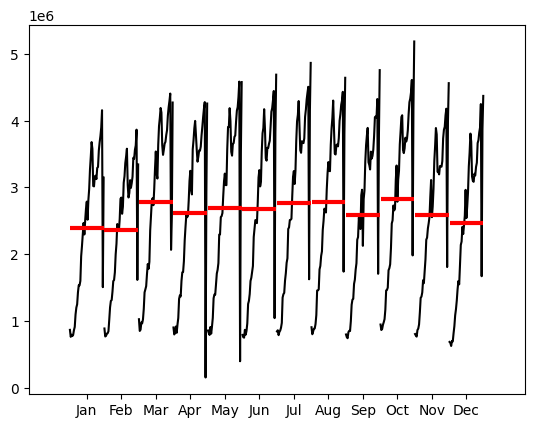

In [18]:
month_plot(train_eda['Value']);

The plot indicates that March and October are two of the busiest months while January, February, and September are slower than the other months.

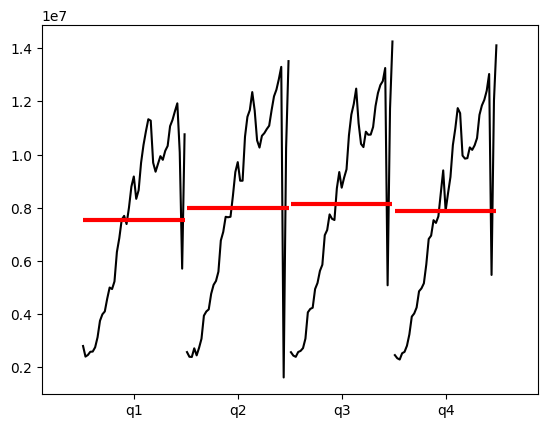

In [19]:
dfq = train_eda['Value'].resample(rule='QE').sum()

quarter_plot(dfq);

## Model 1: Triple Exponential Smoothing Algorithm (Holt-Winters)
Now, let's try one of the time series forecasting techniques called _Exponential Smoothing_, a forecasting method that applies exponentially decreasing weights to past observations, meaning more recent observations are given more weight than older ones. There are three main types of exponential smoothing:
1. Simple Exponential Smoothing (SES):
    - This is used when there is no clear trend or seasonality in the data. It only considers the level of the data.
2. Double Exponential Smoothing (Holt’s Linear Trend Model):
    - Extends simple exponential smoothing by including a component for trend.
3. Triple Exponential Smoothing (Holt-Winters Method):
    - Extends double exponential smoothing by adding a seasonal component. This method is particularly useful for time series data that exhibit both trend and seasonality.
    
We know that there is both trend and seasonality in our dataset, so we will use Triple Exponential Smoothing.

In [20]:
train_hw = train.copy()
test_hw = test.copy()

scaler = MinMaxScaler()
scaled_ts = scaler.fit_transform(train_hw['Value'].values.reshape(-1, 1))

model = ExponentialSmoothing(scaled_ts, trend='add', seasonal='add', seasonal_periods=12)
fitted_model = model.fit()

scaled_forecasted_values = fitted_model.forecast(12).reshape(-1, 1)
actual_forecast = scaler.inverse_transform(scaled_forecasted_values)

actual_forecast = pd.Series(actual_forecast.flatten(), index = test_hw.index, name = 'Forecast')

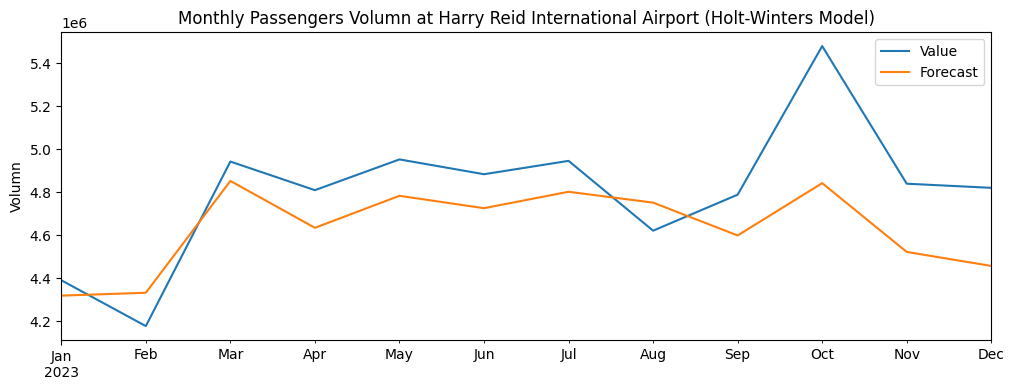

In [21]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport (Holt-Winters Model)'
ylabel='Volumn'
xlabel=''

ax = test_hw['Value'].plot(legend=True,figsize=(12,4),title=title)
actual_forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

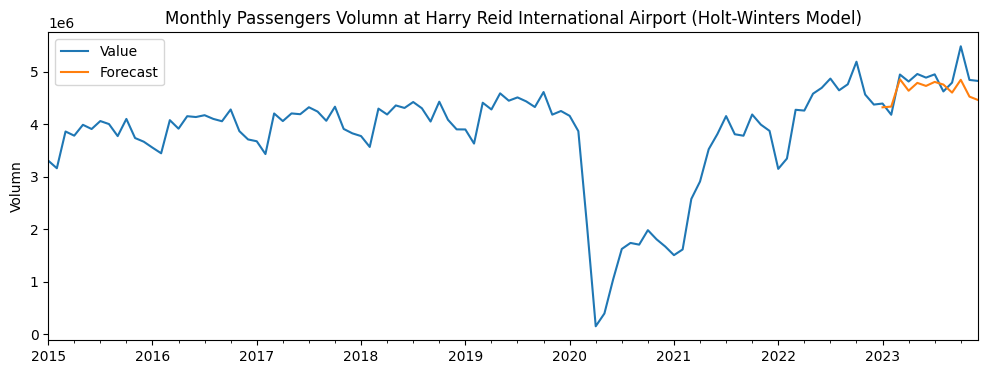

In [61]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport (Holt-Winters Model)'
ylabel='Volumn'
xlabel=''

ax = all_df['Value'].loc['2015-01-01':].plot(legend=True,figsize=(12,4),title=title)
actual_forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [23]:
error_rmse = rmse(test_hw['Value'], actual_forecast)

print(f'Triple Exponential Smoothing (Holt-Winters) RMSE Error: {error_rmse.round(3)}')

Triple Exponential Smoothing (Holt-Winters) RMSE Error: 263797.455


It failed to capture the upward trend in Octover 2023, but this is a descent result considering the model's simplicity!

## EDA Part 2
### Stationarity
Time series data is said to be _stationary_ if it does not exhibit trends or seasonality (i.e., fluctuations in the data are entirely due to outside forces and noise). More mathematically put, a time series is _stationary_ if the mean and variance are fixed between any two equidistant points (i.e., no matter where you take your observations, the results should be the same). Stationarity is important for ARIMA based models, which we are going to experiment with soon, because the model's assumptions and properties are based on the concept of stationarity. For this reason, __transforming a non-stationary series into a stationary one is often a key step in time series analysis__.

A test for stationarity usually involves a __unit root__ hypothesis test, where the null hypothesis $H_0$ is that the series is nonstationary, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity. The _augmented Dickey-Fuller_ is one of the commonly used stationarity tests.

In [24]:
adf_test(train_eda['Value'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.387086
p-value                   0.588451
# lags used              18.000000
# observations          497.000000
critical value (1%)      -3.443576
critical value (5%)      -2.867373
critical value (10%)     -2.569877
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Transforming non-stationary data into stationary one can be done through _differencing_. A simple differencing method calculates the difference between consecutive points.

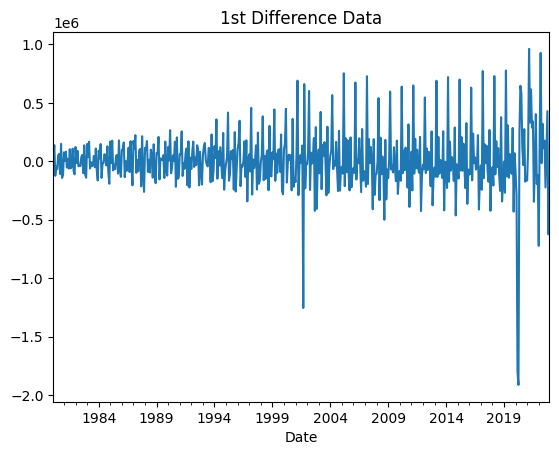

In [25]:
train_eda.loc[:, 'diff1'] = diff(train_eda['Value'], k_diff=1)

train_eda['diff1'].plot(title="1st Difference Data").autoscale(axis='x',tight=True);

In [26]:
adf_test(train_eda['diff1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.854245e+00
p-value                 1.664080e-09
# lags used             1.700000e+01
# observations          4.970000e+02
critical value (1%)    -3.443576e+00
critical value (5%)    -2.867373e+00
critical value (10%)   -2.569877e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


One differencing successfully transformed our passenger data from non-stationary into stationary.

### Autocorrelation / Partial Autocorrelation
In time series analysis, it is important to understand the relationship between observations in a time series at different points in time. _Autocorrelation_ shows how observations are related over time, including the indirect effects through intermediate lags. It is useful for identifying overall patterns and seasonality. _Partial Autocorrelation_ focuses on the direct relationship between the time series and its lagged values. It is particulally useful for identifying the order of an autoregressive model (AR) in time series modeling.

The ``lag_plot()`` function in pandas tells you correlation between time steps:
- If the points in the plot form a clear diagonal line, it suggests that there is a strong correlation between the time series and its lagged version. This can indicate that the time series is strongly autocorrelated at the given lag. 
- If the points are scattered randomly with no discernible pattern, it suggests a weak or no correlation between the time series and its lagged version.

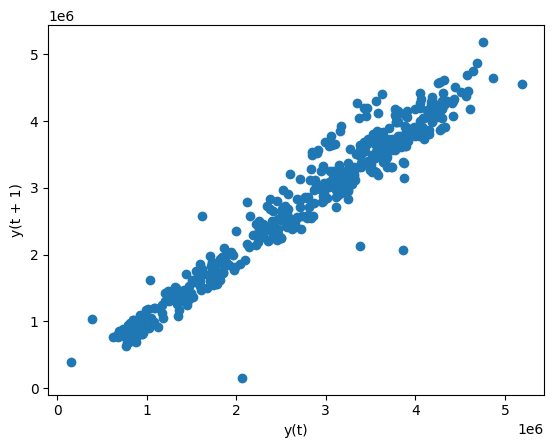

In [27]:
lag_plot(train_eda['Value']);

Below is the custom lagplot function that plots a lag plot for each lag.

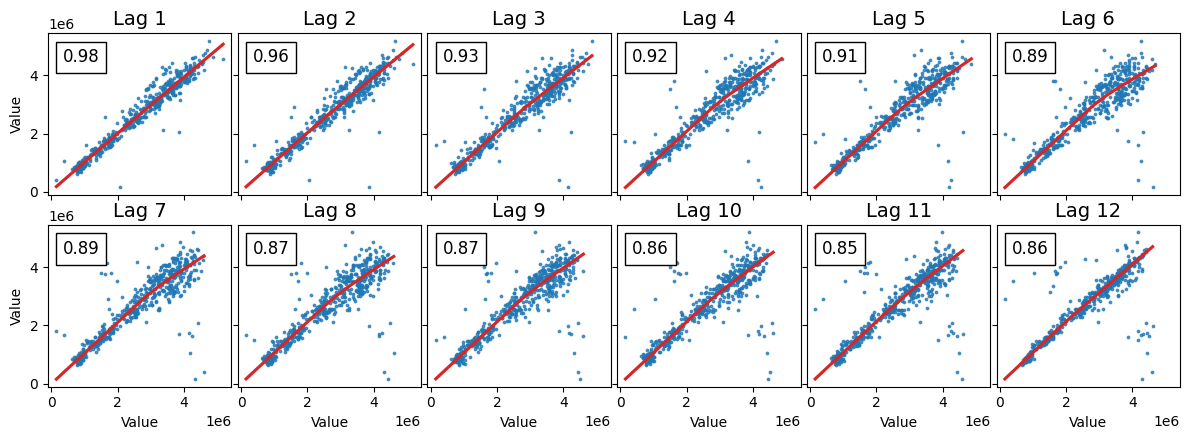

In [28]:
plot_lags(train_eda['Value'], lags=12, nrows=2);

Visually this shows evidence of a very strong autocorrelation.

### ACF Plot
Now, let's plot the magnitude of the autocorrelations over the specificed lags. 

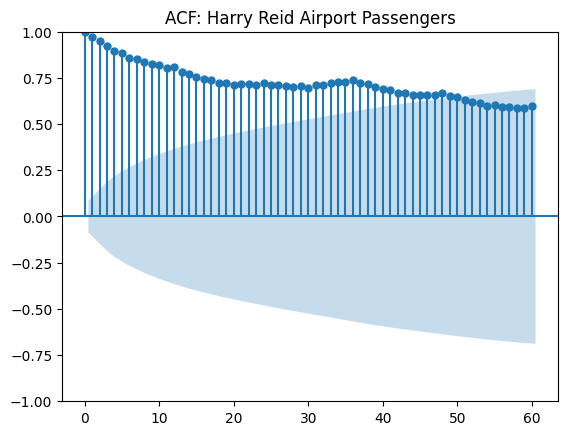

In [29]:
title = 'ACF: Harry Reid Airport Passengers'
lags = 60
plot_acf(train_eda['Value'],title=title,lags=lags);

This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off.

### PACF Plot
Partial autocorrelations work best with stationary data beacuse the PACF measures the direct relationship between a time series and its lags after removing the influence of any intervening lags. This assumes that the relationship between the series and its lags is consistent over time, which is a key property of stationary data. What happens with non-stationary data? Non-stationary data often shows strong correlations across many lags simply due to trends or seasonality, rather than any real direct relationship. This can cause the PACF plot to suggest misleadingly more significant lags than actually exist.

#### PACF with Non-Stationary Data

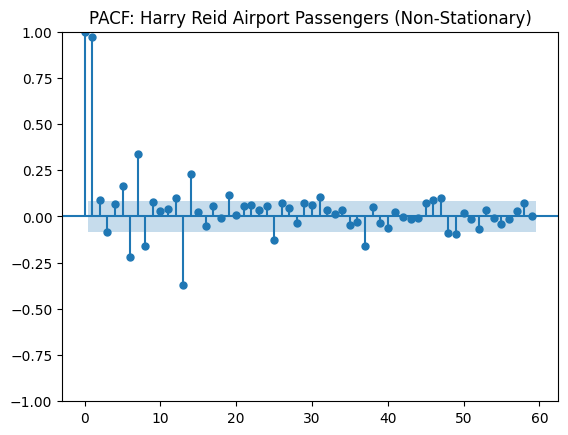

In [30]:
title='PACF: Harry Reid Airport Passengers (Non-Stationary)'
lags=60
plot_pacf(train_eda['Value'],title=title,lags=np.arange(lags));

#### PACF with Stationary Data

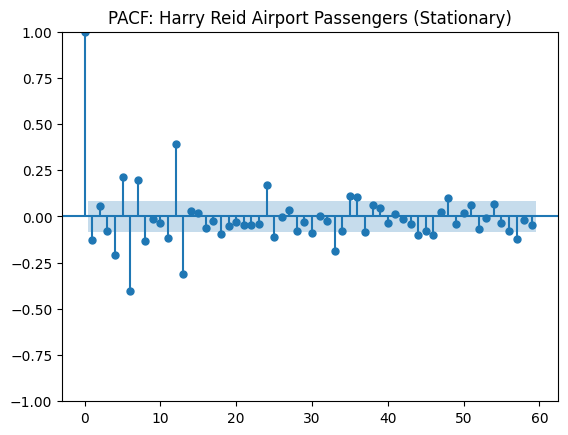

In [31]:
title='PACF: Harry Reid Airport Passengers (Stationary)'
lags=60
plot_pacf(train_eda['diff1'].dropna(),title=title,lags=np.arange(lags));  # be sure to add .dropna() here

## Model 2: ARIMA-based Algorithms
### Understand ARIMA Components
Before we apply a forecasting model, we need to understand the components of one. ARIMA, or Autoregressive Independent Moving Average is actually a combination of 3 models:
1. __AR(p)__ Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
2. __I(d)__ Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
3. __MA(q)__ Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

There is an extension of the ARIMA model that handles seasonality in time series data: SARIMA. Where ARIMA accepts the parameters (p,d,q), SARIMA accepts an additional set of parameters (P,D,Q)m that specifically describe the seasonal components of the model. Here P,D, and Q represent the seasonal regression, differencing and moving average coefficients, and m represents the number of data points (rows) in each seasonal cycle. Note that the statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports exogenous regressor variables.

### Choosing ARIMA Orders
The classical method to decide ARIMA orders is to read ACF and PACF plots. 
- Depending on the dataset, it is common to only require AR or MA components, and we may not need both.
- If the autocorrelation plot shows positive autocorrelation at the first lag, then it suggests to use the AR terms in relation to the lag. 
- If the autocorrelation plot shows negative autocorrelation at the first lag, then it suggests to use the MA terms.
- Typically, a sharp drop after lag "k" suggests an AR-k model should be used. If there is a gradual decline, it suggests an MA model.
- Identification of an AR model is often best done with the PACF, while identification of an MA model is often best done with the ACF.


In our case, a slow decay in the ACF plot suggests the need for an AR term rather than an MA term. The PACF plot cuts off sharply after a first lag, this indicates the potential order p of the AR component. We already know from the adfuller test that we need at least one-level differencing. 

However, __it can be very difficulat to read these plots, so it is often more effective to perform a grid search across various combinations of p,d,q values__. The ``pmdarima`` is a separate library designed to perform grid searches across multiple combinations of p,d,q and also seasonal components P,D,Q. This is by far the most effective way to get good fitting models. Note that the pmdarima library utilizes the _Akaike Information Criterion (AIC)_ as a metric to compare the performance of various ARIMA based models. The AIC evaluates a collection of models and estimates the quality of each model relative to the others. Penalties are provided for the number of parameters used in an effort to thwart overfitting. The lower the AIC, the better the model should be at forecasting.

In [32]:
train_arima = train.copy()
test_arima = test.copy()

In [33]:
auto_arima(train_arima['Value'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  516
Model:             SARIMAX(5, 1, 5)x(2, 0, [1, 2], 12)   Log Likelihood               -6956.720
Date:                                 Tue, 10 Sep 2024   AIC                          13943.439
Time:                                         16:37:42   BIC                          14007.102
Sample:                                     01-01-1980   HQIC                         13968.389
                                          - 12-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1635      0.849     -0.193      0.847      -1.828       1.501
ar.L2          0.8129      0.666      1.221      0.222      -0.492       2.118
ar.L3          0.2878      0.566      0.508      0.611      -0.822       1.398
ar.L4         -0.3924      0.735     -0.534      0.593      -1.833       1.048
ar.L5          0.2630      0.229      1.146      0.252      -0.187       0.713
ma.L1          0.4619      0.853      0.541      0.588      -1.211       2.135
ma.L2         -0.7989      0.915     -0.873      0.383      -2.593       0.995
ma.L3         -0.7404      0.438     -1.692      0.091      -1.598       0.117
ma.L4          0.1588      1.021      0.156      0.876      -1.842       2.159
ma.L5         -0.0490      0.385     -0.127      0.899      -0.804       0.706
ar.S.L12       0.8182     67.715      0.012      0.990    -131.901     133.538
ar.S.L24       0.1451     65.583      0.002      0.998    -128.396     128.686
ma.S.L12      -0.6696     67.728     -0.010      0.992    -133.413     132.074
ma.S.L24      -0.1210     55.514     -0.002      0.998    -108.927     108.685
sigma2      4.446e+10   8.55e-08    5.2e+17      0.000    4.45e+10    4.45e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            133779.51
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.76   Skew:                            -5.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        81.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.43e+34. Standard errors may be unstable.
"""

Great! This provides an ARIMA Order of (5,1,5) combined with a seasonal order of (2,0,\[1,2]\,12). Notice that the seasonal MA order is \[1,2]\. This notation specifies that the model includes both the first and second lag of the seasonal moving average component. This allows the model to account for the influence of past seasonal errors at these two lags. It provides flexibility in capturing more complex seasonal patterns.

In [35]:
model = SARIMAX(train_arima['Value'],order=(5,1,5),seasonal_order=(2,0,[1,2],12), enforce_invertibility=False)
results = model.fit(maxiter=500, disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Value   No. Observations:                  516
Model:             SARIMAX(5, 1, 5)x(2, 0, [1, 2], 12)   Log Likelihood               -6955.763
Date:                                 Tue, 10 Sep 2024   AIC                          13941.526
Time:                                         16:41:56   BIC                          14005.189
Sample:                                     01-01-1980   HQIC                         13966.476
                                          - 12-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7741      0.826     -0.937      0.349      -2.392       0.844
ar.L2          0.3429      0.560      0.612      0.540      -0.755       1.441
ar.L3          0.6386      0.599      1.065      0.287      -0.536       1.814
ar.L4          0.0990      0.649      0.152      0.879      -1.174       1.372
ar.L5          0.2360      0.256      0.922      0.357      -0.266       0.738
ma.L1          1.0784      0.838      1.286      0.198      -0.565       2.721
ma.L2         -0.1366      0.811     -0.168      0.866      -1.726       1.453
ma.L3         -0.9872      0.472     -2.092      0.036      -1.912      -0.062
ma.L4         -0.5741      0.944     -0.608      0.543      -2.424       1.276
ma.L5         -0.3016      0.277     -1.088      0.277      -0.845       0.242
ar.S.L12       0.3697      2.845      0.130      0.897      -5.206       5.946
ar.S.L24       0.5760      2.715      0.212      0.832      -4.746       5.898
ma.S.L12      -0.1934      2.831     -0.068      0.946      -5.742       5.356
ma.S.L24      -0.5104      2.213     -0.231      0.818      -4.847       3.827
sigma2      4.446e+10   4.39e-09   1.01e+19      0.000    4.45e+10    4.45e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            130733.76
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               9.66   Skew:                            -5.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        80.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.32e+33. Standard errors may be unstable.
"""

In [37]:
start=len(train_arima)
end=len(train_arima)+len(test_arima)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(5,1,5)(2,0,[1,2],12) Predictions')

Passing ``dynamic=False`` means that forecasts at each point are generated using the full history up to that point (all lagged values). Passing ``typ='levels'`` predicts the levels of the original endogenous variables. If we'd used the default ``typ='linear'`` we would have seen linear predictions in terms of the differenced endogenous variables.

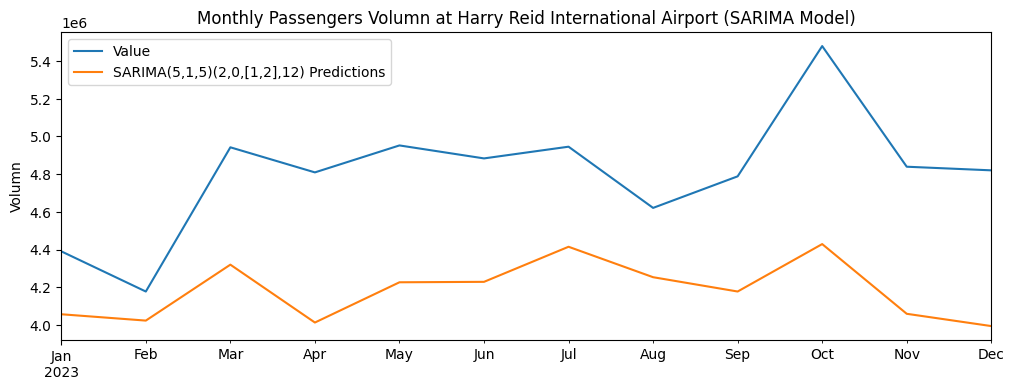

In [38]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport (SARIMA Model)'
ylabel='Volumn'
xlabel=''

ax = test_arima['Value'].plot(legend=True,figsize=(12,4),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

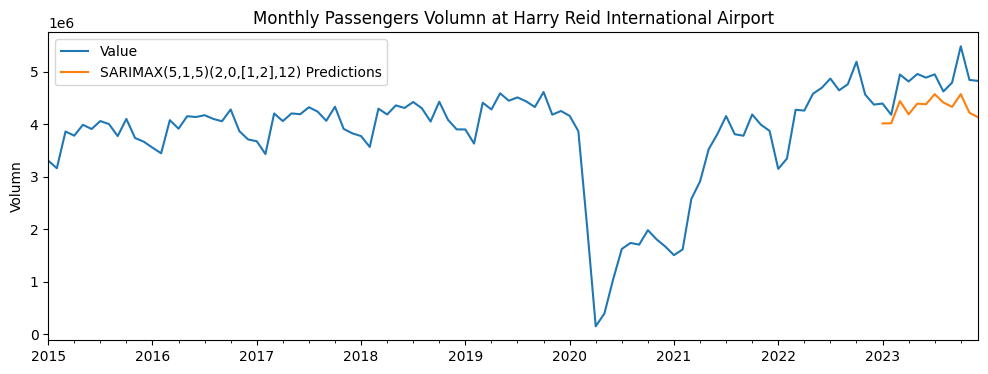

In [62]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport'
ylabel='Volumn'
xlabel=''

ax = all_df['Value'].loc['2015-01-01':].plot(legend=True,figsize=(12,4),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Unfortunately, the model's performance is clearly worse than the Holt-Winters model. Let's evaluate it using RMSE.

In [40]:
error_rmse = rmse(test_arima['Value'], predictions)

print(f'SARIMA(5,1,5)(2,0,[1,2],12) RMSE Error: {error_rmse.round(3)}')

SARIMA(5,1,5)(2,0,[1,2],12) RMSE Error: 664830.75


So far we have considered past values of the dataset and past errors to determine future trends, seasonality, and forecasted values. But even our best performing SARIMA model (according to pmdarima grid search) did not yield a good result. We need models that introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.

### Exogenous Variables (Holidays/Special Events/Months)

In [41]:
years_range = range(1980, 2024)

US_holiday_df = create_holiday_df(holidays.US, years_range, 'US_Holiday')
CA_holiday_df = create_holiday_df(holidays.CA, years_range, 'CA_Holiday')
MX_holiday_df = create_holiday_df(holidays.MX, years_range, 'MX_Holiday')

In [42]:
date_idx = pd.date_range(start='1980-01-01', end='2024-12-01')
date_idx_df = pd.DataFrame(date_idx, columns=['Date'])

holiday_df = (pd.merge(date_idx_df, US_holiday_df, how='left', on='Date')
              .merge(CA_holiday_df, how='left', on='Date')
              .merge(MX_holiday_df, how='left', on='Date'))

holiday_df

,Date,US_Holiday,CA_Holiday,MX_Holiday
0,1980-01-01,New Year's Day,New Year's Day,Año Nuevo
1,1980-01-02,NaN,NaN,NaN
2,1980-01-03,NaN,NaN,NaN
3,1980-01-04,NaN,NaN,NaN
4,1980-01-05,NaN,NaN,NaN
...,...,...,...,...
16402,2024-11-27,NaN,NaN,NaN
16403,2024-11-28,NaN,NaN,NaN
16404,2024-11-29,NaN,NaN,NaN
16405,2024-11-30,NaN,NaN,NaN


In [43]:
holiday_df = holiday_df.set_index('Date')
resampled_holiday_df = holiday_df.resample('MS').count()

In [44]:
exog_df = resampled_holiday_df.copy()
exog_df['Month'] = exog_df.index.month.astype('category')
exog_df = pd.get_dummies(exog_df, dtype=np.int8, drop_first=True)
exog_df = add_special_events(exog_df)

exog_df

,US_Holiday,CA_Holiday,MX_Holiday,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Special_Events
Date,,,,,,,,,,,,,,,
1980-01-01,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1980-02-01,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1980-03-01,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1980-04-01,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0
1980-05-01,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2024-09-01,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2024-10-01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [45]:
exog_train = exog_df.iloc[:-24] # 1980-2022
exog_test = exog_df.iloc[-24:-12] # year 2023

In [47]:
model = SARIMAX(train_eda['Value'], exog=exog_train, order=(5,1,5),seasonal_order=(2,0,[1,2],12), enforce_invertibility=False)
results = model.fit(maxiter=500, disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   Value   No. Observations:                  516
Model:             SARIMAX(5, 1, 5)x(2, 0, [1, 2], 12)   Log Likelihood               -6897.773
Date:                                 Tue, 10 Sep 2024   AIC                          13855.545
Time:                                         16:49:54   BIC                          13982.870
Sample:                                     01-01-1980   HQIC                         13905.444
                                          - 12-01-2022                                         
Covariance Type:                                   opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
US_Holiday      1.495e+04   1.59e+04      0.937      0.349   -1.63e+04    4.62e+04
CA_Holiday     -1.301e+04   1.37e+04     -0.947      0.344   -3.99e+04    1.39e+04
MX_Holiday     -1.902e+04   6.61e+04     -0.288      0.774   -1.49e+05    1.11e+05
Month_2        -2.712e+04    6.3e+04     -0.430      0.667   -1.51e+05    9.64e+04
Month_3         4.069e+05   4.95e+04      8.218      0.000     3.1e+05    5.04e+05
Month_4         2.299e+05    6.8e+04      3.384      0.001    9.68e+04    3.63e+05
Month_5         3.054e+05   6.27e+04      4.872      0.000    1.83e+05    4.28e+05
Month_6         2.613e+05   5.58e+04      4.682      0.000    1.52e+05    3.71e+05
Month_7         3.481e+05    6.8e+04      5.122      0.000    2.15e+05    4.81e+05
Month_8         3.727e+05   4.66e+04      7.994      0.000    2.81e+05    4.64e+05
Month_9         1.817e+05   7.17e+04      2.535      0.011    4.12e+04    3.22e+05
Month_10        3.762e+05   8.94e+04      4.208      0.000    2.01e+05    5.51e+05
Month_11        1.085e+05   6.43e+04      1.688      0.091   -1.75e+04    2.35e+05
Month_12        5.228e+04   7.17e+04      0.730      0.466   -8.82e+04    1.93e+05
Special_Events -5.032e+05   2.83e+04    -17.777      0.000   -5.59e+05   -4.48e+05
ar.L1             -0.3664      0.596     -0.615      0.539      -1.535       0.802
ar.L2              0.6476      0.474      1.365      0.172      -0.282       1.577
ar.L3              0.3837      0.384      0.999      0.318      -0.369       1.136
ar.L4             -0.2199      0.506     -0.434      0.664      -1.212       0.772
ar.L5              0.2768      0.162      1.706      0.088      -0.041       0.595
ma.L1              0.6225      0.597      1.043      0.297      -0.547       1.792
ma.L2             -0.6557      0.625     -1.049      0.294      -1.881       0.569
ma.L3             -0.8280      0.347     -2.384      0.017      -1.509      -0.147
ma.L4             -0.0632      0.742     -0.085      0.932      -1.517       1.390
ma.L5             -0.1364      0.269     -0.508      0.612      -0.663       0.390
ar.S.L12           0.2344     13.385      0.018      0.986     -25.999      26.468
ar.S.L24           0.6238     12.316      0.051      0.960     -23.515      24.762
ma.S.L12          -0.1001     13.397     -0.007      0.994     -26.358      26.158
ma.S.L24          -0.5265     10.517     -0.050      0.960     -21.139      20.086
sigma2          2.837e+10      2.381   1.19e+10      0.000    2.84e+10    2.84e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             51338.12
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               8.14   Skew:                            -4.53
Prob(H) (two-

In [49]:
start=len(train_arima)
end=len(train_arima)+len(test_arima)-1
predictions = results.predict(start=start, end=end, exog=exog_test, dynamic=False, typ='levels').rename('SARIMAX(5,1,5)(2,0,[1,2],12) Predictions')

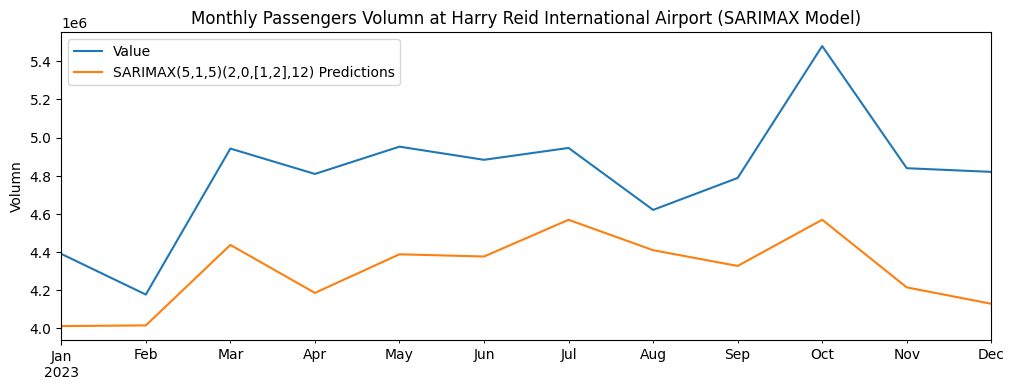

In [50]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport (SARIMAX Model)'
ylabel='Volumn'
xlabel=''

ax = test_arima['Value'].plot(legend=True,figsize=(12,4),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

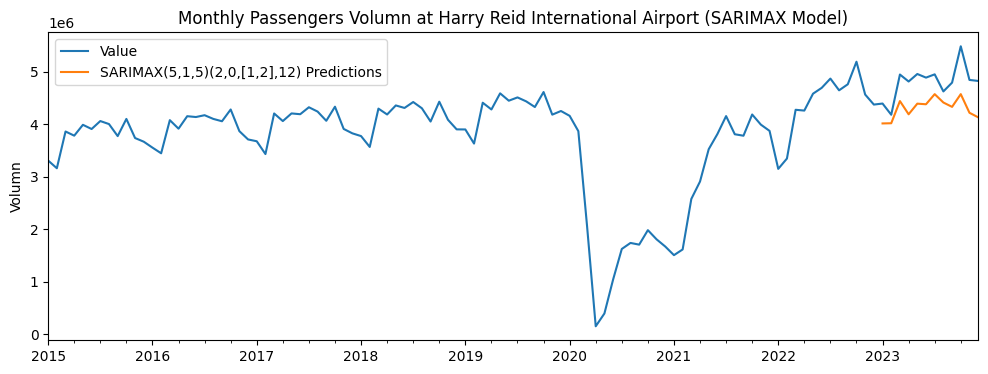

In [63]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport (SARIMAX Model)'
ylabel='Volumn'
xlabel=''

ax = all_df['Value'].loc['2015-01-01':].plot(legend=True,figsize=(12,4),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [64]:
error_rmse = rmse(test_arima['Value'], predictions)

print(f'SARIMAX(5,1,5)(2,0,[1,2],12) RMSE Error: {error_rmse.round(3)}')

SARIMAX(5,1,5)(2,0,[1,2],12) RMSE Error: 539003.763


The SARIMA model got a lot better with exogious variables but the score is still lower than the Holt-Winters model.

## Model 3: Hybrid
We have explored the Holt-Winters model and the SARIMAX model so far. Let's now create a "hybrid" forecaster that combines complementary learning algorithms and let the strengths of one make up for the weakness of the other. I will use ``LinearRegression`` to extrapolate the trend, transform the target to remove the trend, and then apply ``XGBoostRegressor`` to the detrended residuals.


### Linear Regression (Trend/Seasonality)
First let's use a linear regression model to learn the trend and seasonarity. Here we will utilize a ``DeterministicProcess`` class to create deterministic terms, such as trend and seasonal components. We can specify ``seasonal = True`` to capture any repetitive patterns, but if the data has more complex seasonality that might not be well captured by simple seasonal dummies, we can use Fourier terms. 

In [53]:
train_hybrid = train.copy()
test_hybrid = test.copy()

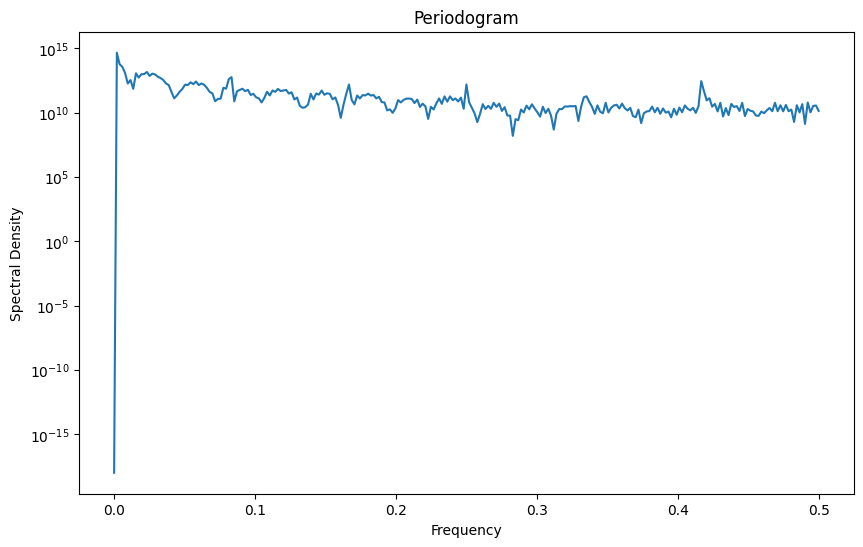

In [54]:
f, Pxx = periodogram(train_hybrid['Value'])

# Plot periodogram
plt.figure(figsize=(10, 6))
plt.semilogy(f, Pxx)
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.show()

In [55]:
fourier = CalendarFourier(freq="YE", order=5)

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
    seasonal=True,
    additional_terms=[fourier],  # annual seasonality (fourier)
)

X = dp.in_sample()  # features for the training data
X = add_temperature_level(X)
X = add_special_events(X)
y = all_df['Value']

lag_features = make_lags(y, lags=1)

X_concat = pd.concat([X,lag_features], axis=1) # additional_features
count_nulls = X_concat.isna().sum().max()
X_concat = X_concat.dropna()

y = df.iloc[count_nulls:]


X_train = X_concat.iloc[:-12] # Dec 1980-2022
X_test = X_concat.iloc[-12:] # year 2023

y_train = y.iloc[:-12] # 1980-2022
y_test = y.iloc[-12:] # year 2023

X_train

,const,trend,trend_squared,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)",...,"sin(3,freq=YE-DEC)","cos(3,freq=YE-DEC)","sin(4,freq=YE-DEC)","cos(4,freq=YE-DEC)","sin(5,freq=YE-DEC)","cos(5,freq=YE-DEC)",Low_Temperature,Moderate_Temperature,Special_Events,y_lag_1
Date,,,,,,,,,,,,,,,,,,,,,
1980-02-01,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999668,-0.025748,0.848351,-0.529434,0.462383,-0.886680,1,0,0,865759.0
1980-03-01,1.0,3.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.051479,-0.998674,-0.829677,-0.558244,-0.905702,0.423914,0,1,0,886371.0
1980-04-01,1.0,4.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.999668,-0.025748,-0.034328,0.999411,0.999079,0.042905,0,1,0,1025072.0
1980-05-01,1.0,5.0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.051479,0.998674,0.898292,-0.439400,-0.819972,-0.572404,0,1,0,901473.0
1980-06-01,1.0,6.0,36.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.999668,0.025748,-0.848351,-0.529434,0.462383,0.886680,0,0,0,856507.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,1.0,512.0,262144.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.998880,-0.047321,0.895839,-0.444378,-0.566702,0.823923,0,0,0,4865078.0
2022-09-01,1.0,513.0,263169.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.017213,0.999852,-0.854322,-0.519744,0.880012,-0.474951,0,0,0,4642120.0
2022-10-01,1.0,514.0,264196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999250,0.038722,-0.051620,0.998667,-0.997917,-0.064508,0,1,0,4756732.0


In [56]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# # Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
).astype(np.int32)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
).astype(np.int32)

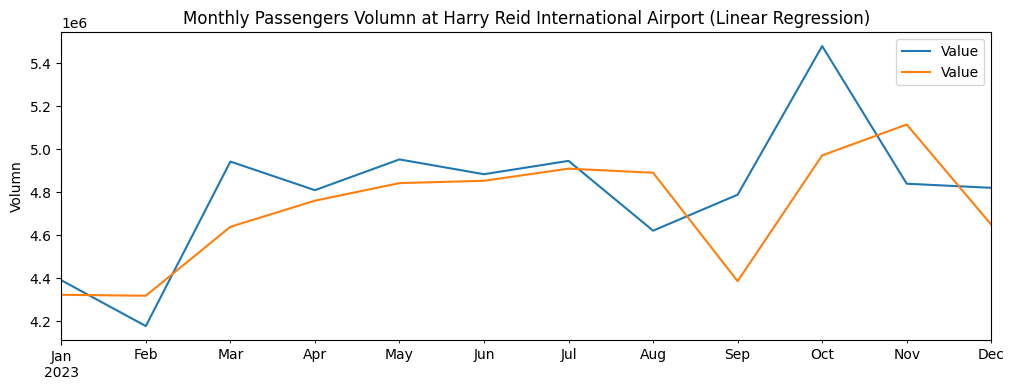

In [60]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport (Linear Regression)'
ylabel='Volumn'
xlabel=''

ax = test_hybrid['Value'].plot(legend=True,figsize=(12,4),title=title)
y_pred.squeeze().plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

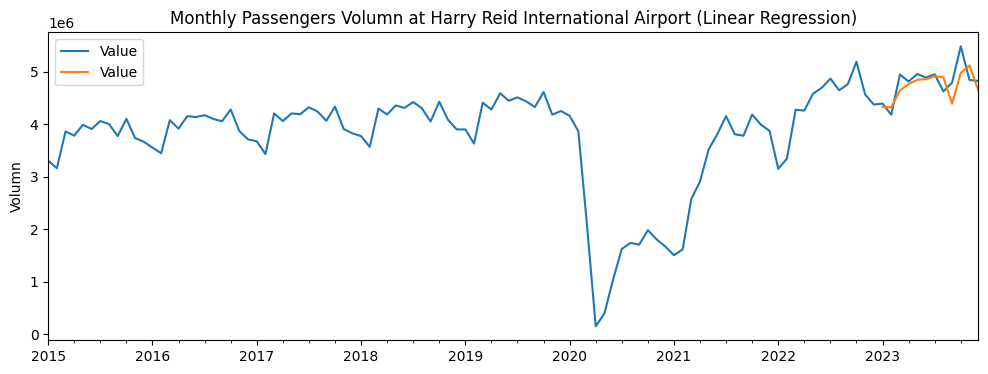

In [65]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport (Linear Regression)'
ylabel='Volumn'
xlabel=''

ax = all_df['Value'].loc['2015-01-01':].plot(legend=True,figsize=(12,4),title=title)
y_pred.squeeze().plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [71]:
error_rmse = mean_squared_error(test['Value'], model.predict(X_test), squared=False)

print(f'Linear Regression RMSE Error: {error_rmse.round(3)}')

Linear Regression RMSE Error: 246995.861


Very nice! We got a better RMSE score than the Holt-Winters model. I created only one lag feature, but let's look at the PACF plot again.

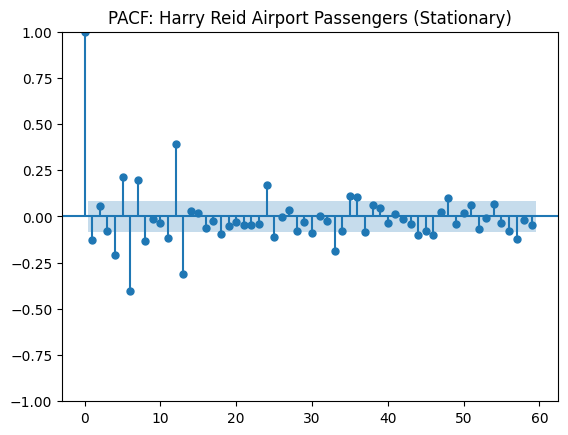

In [72]:
title='PACF: Harry Reid Airport Passengers (Stationary)'
lags=60
plot_pacf(train_eda['diff1'].dropna(),title=title,lags=np.arange(lags));  # be sure to add .dropna() here

It is hard to decide the number of lags to use with this plot, but let's try lag-1 through lag-15 and see which model performs the best.

In [73]:
error_rmse_dict = {}

for i in range(1,16):
    
    dp = DeterministicProcess(
        index=df.index,  # dates from the training data
        constant=True,  # the intercept
        order=2,        # quadratic trend
        drop=True,      # drop terms to avoid collinearity
        seasonal=True,
        additional_terms=[fourier],  # annual seasonality (fourier)
    )

    X = dp.in_sample()  # features for the training data
    X = add_temperature_level(X)
    X = add_special_events(X)
    y = all_df['Value']

    lag_features = make_lags(y, lags= i)

    X_concat = pd.concat([X,lag_features], axis=1) # additional_features
    count_nulls = X_concat.isna().sum().max()
    X_concat = X_concat.dropna()
    
    y = df.iloc[count_nulls:]

    X_train = X_concat.iloc[:-12] # Dec 1980-2022
    X_test = X_concat.iloc[-12:] # year 2023

    y_train = y.iloc[:-12] # 1980-2022
    y_test = y.iloc[-12:] # year 2023

    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    error_rmse = mean_squared_error(test_hybrid['Value'], model.predict(X_test), squared=False)
    
    error_rmse_dict[i] = error_rmse
    
pd.Series(error_rmse_dict).sort_values()

1     246995.861500
2     268589.159220
14    269657.441769
13    270774.494799
3     271346.285845
5     272162.714705
15    272637.757457
4     275720.118559
6     280207.947281
10    287376.655259
12    288475.617606
7     290075.657645
11    292619.184294
9     295682.486501
8     297454.780178
dtype: float64

Perfect, the lag-1 model had the best rmse score. This is good as we are now less concerned about overfitting and can keep our model simpler.

In [74]:
dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
    seasonal=True,
    additional_terms=[fourier],  # annual seasonality (fourier)
)

X = dp.in_sample()  # features for the training data
X = add_temperature_level(X)
X = add_special_events(X)
y = all_df['Value']

lag_features = make_lags(y, lags= 1)

X_concat = pd.concat([X,lag_features], axis=1) # additional_features
count_nulls = X_concat.isna().sum().max()
X_concat = X_concat.dropna()

y = df.iloc[count_nulls:]

X_train = X_concat.iloc[:-12] # Dec 1980-2022
X_test = X_concat.iloc[-12:] # year 2023

y_train = y.iloc[:-12] # 1980-2022
y_test = y.iloc[-12:] # year 2023

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# # Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
).astype(np.int32)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
).astype(np.int32)

### XGBRegressor (Residuals)

In [75]:
# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = pd.DataFrame(pd.Series(xgb.predict(X_train) + np.array(y_fit).flatten(), index=X_train.index, name='y_fit_boosted'))
y_pred_boosted = pd.DataFrame(pd.Series(xgb.predict(X_test) + np.array(y_pred).flatten(), index=X_test.index, name='y_pred_boosted'))

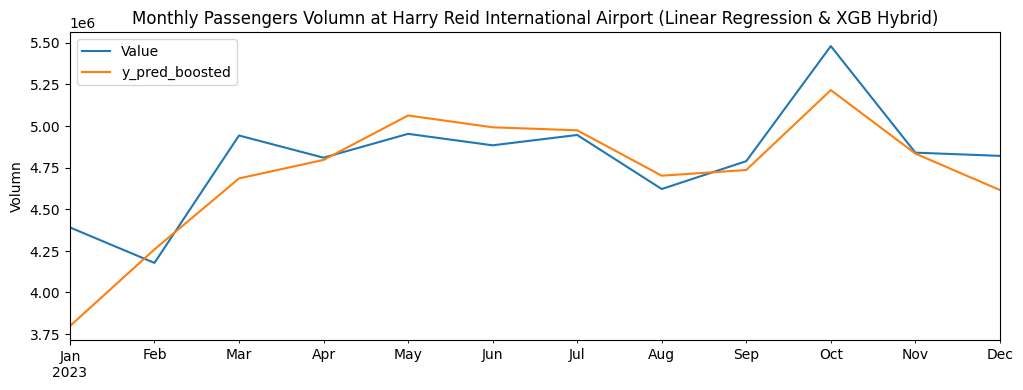

In [76]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport (Linear Regression & XGB Hybrid)'
ylabel='Volumn'
xlabel=''

ax = test['Value'].plot(legend=True,figsize=(12,4),title=title)
y_pred_boosted.squeeze().plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

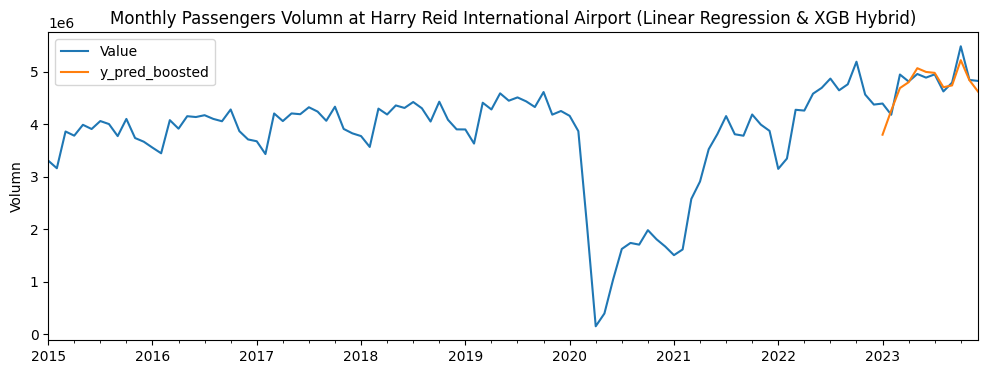

In [77]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport (Linear Regression & XGB Hybrid)'
ylabel='Volumn'
xlabel=''

ax = all_df['Value'].loc['2015-01-01':].plot(legend=True,figsize=(12,4),title=title)
y_pred_boosted.squeeze().plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [78]:
error_rmse = mean_squared_error(test_hybrid['Value'], y_pred_boosted, squared=False)

print(f'Hybrid (Linear Regression & XGBRegressor) RMSE Error: {error_rmse.round(3)}')

Hybrid (Linear Regression & XGBRegressor) RMSE Error: 218099.214


The hybrid model provided the best RMSE score. Let's use this model as our final forecasting model.

## Retrain the Final Model on the Full Data

In [79]:
fourier = CalendarFourier(freq="YE", order=5)

dp = DeterministicProcess(
    index=df.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
    seasonal=True,
    additional_terms=[fourier],  # annual seasonality (fourier)
)

X = dp.in_sample()  # features for the training data
X = add_temperature_level(X)
X = add_special_events(X)
y = all_df['Value']

lag_features = make_lags(y, lags= 1)

X_concat = pd.concat([X,lag_features], axis=1) # additional_features
count_nulls = X_concat.isna().sum().max()
X_concat = X_concat.dropna()

y = df.iloc[count_nulls:]

model = LinearRegression(fit_intercept=False)
model.fit(X_concat, y)

# y_fit = pd.DataFrame(model.predict(X_concat), index=y.index, columns=y.columns).astype(np.int32)
y_pred = pd.DataFrame(model.predict(X_concat), index=y.index, columns=y.columns).astype(np.int32)

y_resid = y - y_pred

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_concat, y_resid)

y_pred_boosted = xgb.predict(X_concat) + np.array(y_pred).flatten()
y_pred_boosted_df = pd.DataFrame(y_pred_boosted, index=X_concat.index).rename(columns={0: 'y_pred_boosted'})

## Forecasting 12-Months Ahead

In [80]:
timestamp = 12
y_history = y.copy()
pred = []

for i in range(timestamp):
    # One timestep ahead of the fitted data points
    new_X_arr = dp.out_of_sample(2 + i).iloc[[i],:]
    new_X_arr = add_temperature_level(new_X_arr)
    new_X_arr = add_special_events(new_X_arr)
    new_X_arr['y_lag_1'] = y_history.iloc[[-1], :].values.flatten()    
    
    current_pred = model.predict(new_X_arr)
    current_pred_boosted = xgb.predict(new_X_arr) + current_pred
    current_pred_boosted_sr = pd.Series(current_pred_boosted.flatten(), index=new_X_arr.index, name='Value')
    
    pred.append(current_pred_boosted)
    y_history = pd.concat([y_history, current_pred_boosted_sr], axis=0)

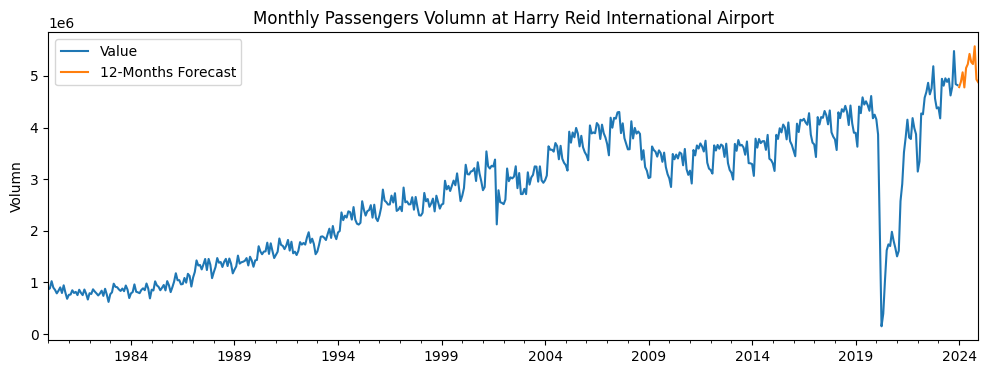

In [81]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport'
ylabel='Volumn'
xlabel=''

ax = df['Value'].plot(legend=True,figsize=(12,4),title=title)
pd.Series(np.array(pred).flatten(), index = dp.out_of_sample(12).index, name='12-Months Forecast').plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

plt.savefig('passenger_volume_forecast.png', bbox_inches='tight');

Our forecast looks good! There is actually 2024 data available for January through July. Let's plot it alongside our forecast and see if how well our forecast performed.

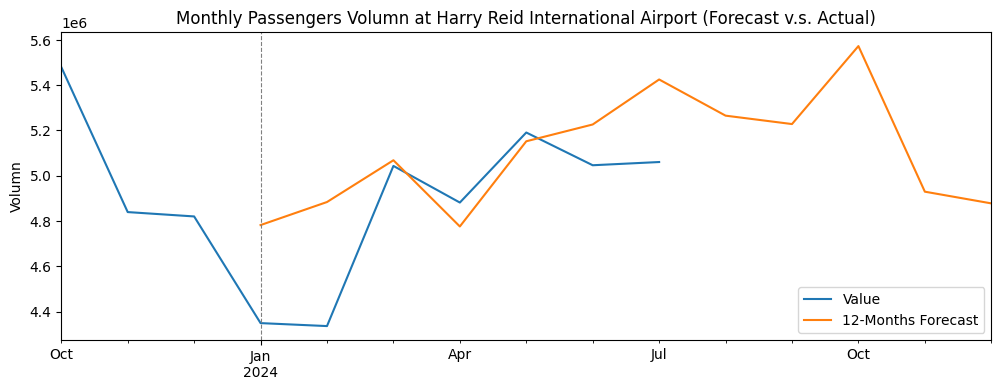

In [82]:
title = 'Monthly Passengers Volumn at Harry Reid International Airport (Forecast v.s. Actual)'
ylabel='Volumn'
xlabel=''

ax = original.loc[original.index >= '2023-10-01','Value'].plot(legend=True,figsize=(12,4),title=title)
pd.Series(np.array(pred).flatten(), index = dp.out_of_sample(12).index, name='12-Months Forecast').plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

vline_date = pd.to_datetime('2024-01-01')

plt.axvline(x=vline_date, color='gray', linestyle='--', linewidth=0.8);

It seems that our forecast for January and February was a bit too optimistic, but we forecasted well for March through May!

## Summary

In this project, we explored three models: Hot-Winters, ARIMA, and Hybrid. It is also common to use deep learning models in time series forecasting tasks, such as LSTM (Long Short Term Memory). I did not explore it here because I previously experimented with it, but it did not perform well enough to convince me to choose it over the hybrid model. But I have included the code I used for the LSTM model below in case anyone is interested.

Additionally, we noticed that our forecast was a bit off for January and February. This variance could be explained by other external factors. For example, if flight tickets were too expensive at the time of booking, some people might have decided not to travel. Another possibility is that a decrease in disposable income might have led people to forego visiting the city, as many activities there are considered luxurious, such as gambling and shopping.

Incorporating these factors might improve our model's forecasting ability, but it would also make the model much more complex, as we would need to forecast gas prices and disposable income for future dates and use them as inputs for passenger volume forecasting. Below, I have plotted the relationship between passenger volumes and gas prices. We can observe a clear relationship, so it might be worth considering incorporating gas prices into the model.

Thank you for reading all the way to the end!

Best, <br>
Seiji

## Supplemental Data
### Relationship between Passenger Volume and Gas Prices

In [83]:
gas = pd.read_csv('/kaggle/input/us-gas-price/US_historical_gas_price.csv', index_col = 'Date', parse_dates=True)
gas.dropna(inplace=True)
gas = gas.rename(columns={'U.S. Regular All Formulations Retail Gasoline Prices (Dollars per Gallon)': 'gas price'})
gas.index = gas.index.to_period('M').to_timestamp('M') + pd.Timedelta(days=1)
gas_joined = gas.join(df).dropna()

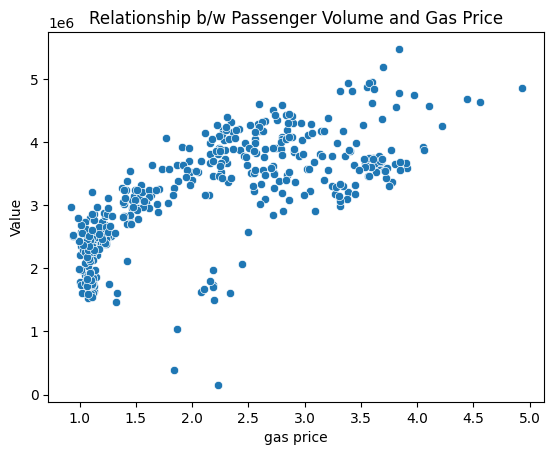

In [84]:
sns.scatterplot(data=gas_joined, x='gas price', y='Value')

plt.title('Relationship b/w Passenger Volume and Gas Price');

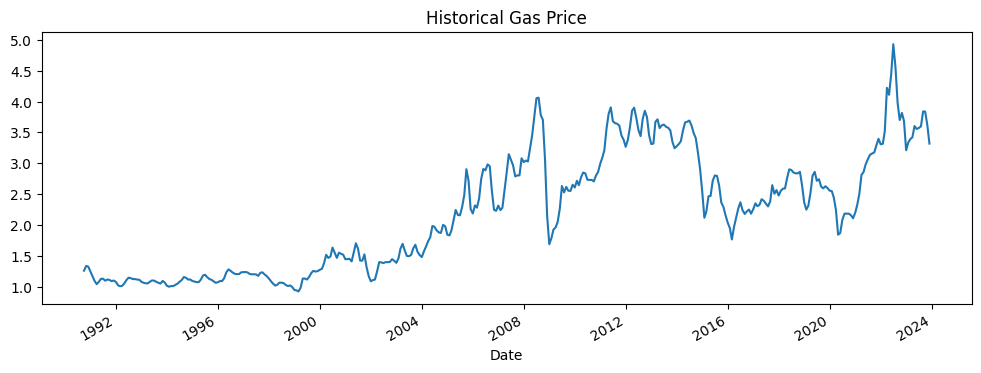

In [85]:
gas_joined['gas price'].plot(figsize=(12,4))

plt.title('Historical Gas Price');

### LSTM Deep Learning Model

In [86]:
# train_lstm = train[['Value']].copy()
# test_lstm = test[['Value']].copy()

# scaler = MinMaxScaler()

# train_scaled = scaler.fit_transform(train_lstm)
# test_scaled = scaler.transform(test_lstm)

In [87]:
# n_input = 12
# n_features = 1
# generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)

In [88]:
# input_shape=(n_input, n_features)

# model = Sequential()
# model.add(Input(shape=input_shape))
# model.add(LSTM(100, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

In [89]:
# model.summary()

In [90]:
# model.fit(generator,epochs=50)

In [91]:
# # holding my predictions
# test_predictions = []

# # last n_input points from the training set
# first_eval_batch = train_scaled[-n_input:]

# # reshape this to the format RNN wants (same format as TimeseriesGenerator)
# current_batch = first_eval_batch.reshape((1,n_input,n_features))

# # how far into the future will I forecast?
# # len(test) --> 12
# for i in range(len(test_scaled)):
    
#     # One timestep ahead of historical 12 points
#     current_pred = model.predict(current_batch)[0]
    
#     # store that prediction
#     test_predictions.append(current_pred)
    
#     # UPDATE current batch to include prediction
#     current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [92]:
# true_test_predictions = scaler.inverse_transform(test_predictions)